<a href="https://colab.research.google.com/github/rodrigoulart/projeto-05-sistema-de-reconhecimento-facial/blob/main/projeto_05_sistema_de_reconhecimento_facial_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
# Importações e configuração do modelo base
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Modelo ResNet50 para extrair embeddings
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Detector de faces do OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


In [110]:
# Funções para detectar faces e gerar embeddings

def detect_faces(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return faces

def get_embedding(face_img):
    face_resized = cv2.resize(face_img, (224, 224))
    x = image.img_to_array(face_resized)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    embedding = base_model.predict(x, verbose=0)
    return embedding.flatten()


Relatório de classificação:
              precision    recall  f1-score   support

   bolsonaro       0.75      1.00      0.86         3
        lula       1.00      1.00      1.00         3
      outros       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.92      0.89      0.89         9
weighted avg       0.92      0.89      0.89         9



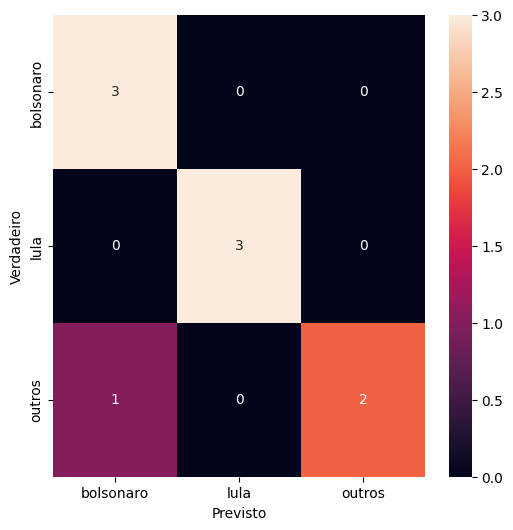


Resumo do dataset processado:
Classe 'bolsonaro': 16 imagens processadas
Classe 'outros': 13 imagens processadas
Classe '.ipynb_checkpoints': 0 imagens processadas
Classe 'lula': 13 imagens processadas


In [111]:
# Processar dataset, treinar classificador e salvar modelos
dataset_path = "dataset"
X, y = [], []

# Contar imagens por classe
class_counts = {}

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if not os.path.isdir(label_path):
        continue
    count = 0
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        faces = detect_faces(img)
        if len(faces) == 0:
            continue
        for (x, y_, w, h) in faces:
            face = img[y_:y_+h, x:x+w]
            embedding = get_embedding(face)
            X.append(embedding)
            y.append(label)
            count += 1
    class_counts[label] = count

X = np.array(X)
y = np.array(y)

# Codificar rótulos
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Treinar SVM
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Avaliar modelo
y_pred = clf.predict(X_test)
print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Matriz de confusão
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

# Salvar modelo e encoder
os.makedirs("outputs", exist_ok=True)
joblib.dump(clf, "outputs/face_classifier.pkl")
joblib.dump(encoder, "outputs/label_encoder.pkl")

# Mostrar resumo de imagens processadas
print("\nResumo do dataset processado:")
for label, count in class_counts.items():
    print(f"Classe '{label}': {count} imagens processadas")


Saving teste_lula_bolsonaro.JPG to teste_lula_bolsonaro.JPG
Imagem enviada: test_images/teste_lula_bolsonaro.JPG


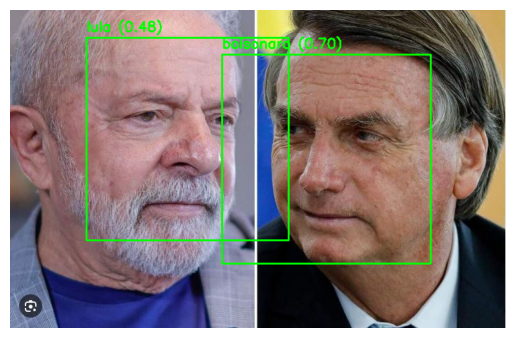

In [112]:
# Enviar imagem e classificar com bounding boxes
from google.colab import files

def upload_and_predict():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img_path = os.path.join("test_images", fn)
        os.makedirs("test_images", exist_ok=True)
        os.rename(fn, img_path)
        print(f"Imagem enviada: {img_path}")

        img = cv2.imread(img_path)
        faces = detect_faces(img)
        clf = joblib.load("outputs/face_classifier.pkl")
        encoder = joblib.load("outputs/label_encoder.pkl")

        for (x, y, w, h) in faces:
            face = img[y:y+h, x:x+w]
            embedding = get_embedding(face)
            pred = clf.predict([embedding])[0]
            prob = np.max(clf.predict_proba([embedding]))
            label = encoder.inverse_transform([pred])[0]

            # Desenhar bounding box e label
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img, f"{label} ({prob:.2f})", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Exibir imagem
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()

# Executar a função
upload_and_predict()
